### Comparison: MLFinLab Labeling vs Custom create_dynamic_triple_barriers

This notebook compares two triple barrier labeling approaches:
1. **MLFinLab Implementation**: Using `get_events()` and `meta_labeling()` from FinancialMachineLearning library
2. **Custom Implementation**: Using `create_dynamic_triple_barriers()` from our feature preprocessing

Both will be tested with RandomForest to evaluate:
- Label distribution balance
- Prediction quality
- Strategy performance (Sharpe ratio)

In [1]:
# Setup path to import modules
import sys
from pathlib import Path

# Add the MLFinance root directory to Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up from Notes/Week05Labeling to MLFinance
equity_ml_root = project_root.parent  # Go up to equity-ml-ldp

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✓ Added {project_root} to Python path")
    
if str(equity_ml_root) not in sys.path:
    sys.path.insert(0, str(equity_ml_root))
    print(f"✓ Added {equity_ml_root} to Python path")

✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance to Python path
✓ Added /mnt/ssd_backup/equity-ml-ldp to Python path


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# MLFinLab imports
from FinancialMachineLearning.labeling.labeling import add_vertical_barrier, get_events, meta_labeling
from FinancialMachineLearning.features.volatility import daily_volatility

# Custom implementation imports
from fin_feature_preprocessing import EnhancedFinancialFeatures
from feature_config import FeatureConfig

print("✓ All imports successful")

✓ All imports successful


### 1. Load Data

In [7]:
start_date = '2015-03-31'
end_date = '2025-09-25'
ticker = 'AAPL'
# Download data with auto_adjust=True (all prices are adjusted)
data_yf = yf.download(
    ticker, 
    start=start_date, 
    end=end_date,
    multi_level_index=False,
    auto_adjust=True
)

print(f"✓ Data loaded: {data_yf.shape}")
print(f"✓ Date range: {data_yf.index[0]} to {data_yf.index[-1]}")
print(f"✓ Columns: {data_yf.columns.tolist()}")
data_yf.head()

[*********************100%***********************]  1 of 1 completed

✓ Data loaded: (2638, 5)
✓ Date range: 2015-03-31 00:00:00 to 2025-09-24 00:00:00
✓ Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


,Close,High,Low,Open,Volume
Date,,,,,
2015-03-31,27.720810,28.179741,27.705215,28.090628,168362400
2015-04-01,27.680708,27.874529,27.424508,27.807694,162485600
2015-04-02,27.919085,27.972552,27.667341,27.854477,128880400
2015-04-06,28.371334,28.406980,27.698532,27.729721,148776000
2015-04-07,28.072807,28.542877,28.066124,28.435942,140049200


In [8]:
# Prepare data for custom implementation (lowercase columns)
data_custom = data_yf.copy()
data_custom.columns = data_custom.columns.str.lower()
print(f"Custom implementation data shape: {data_custom.shape}")
data_custom.head()

Custom implementation data shape: (2638, 5)


,close,high,low,open,volume
Date,,,,,
2015-03-31,27.720810,28.179741,27.705215,28.090628,168362400
2015-04-01,27.680708,27.874529,27.424508,27.807694,162485600
2015-04-02,27.919085,27.972552,27.667341,27.854477,128880400
2015-04-06,28.371334,28.406980,27.698532,27.729721,148776000
2015-04-07,28.072807,28.542877,28.066124,28.435942,140049200


### 2. MLFinLab Implementation

In [9]:
print("="*80)
print("METHOD 1: MLFINLAB IMPLEMENTATION")
print("="*80)

# Step 1: Add vertical barrier (7-day horizon)
vertical_barrier = add_vertical_barrier(
    data_yf.index, 
    data_yf['Close'],
    num_days=7
)
print(f"\n✓ Vertical barriers created: {len(vertical_barrier)} timestamps")

# Step 2: Calculate volatility (60-day lookback)
volatility = daily_volatility(data_yf['Close'], lookback=60)
print(f"✓ Volatility calculated (60-day lookback)")
print(f"  Mean volatility: {volatility.mean():.4f} ({volatility.mean()*100:.2f}%)")
print(f"  Std volatility:  {volatility.std():.4f}")

# Step 3: Get triple barrier events
# pt_sl = [2, 1] means TP = 2× volatility, SL = 1× volatility (asymmetric)
triple_barrier_events_mlf = get_events(
    close=data_yf['Close'],
    t_events=data_yf.index[60:],  # Start after volatility warmup
    pt_sl=[2, 1],  # profit taking 2×, stop loss 1×
    target=volatility,  # dynamic threshold based on volatility
    min_ret=0.005,  # minimum 0.5% return
    num_threads=1,
    vertical_barrier_times=vertical_barrier,
    side_prediction=None  # no primary model
)
print(f"\n✓ Triple barrier events generated: {len(triple_barrier_events_mlf)}")
print(f"\nEvent columns: {triple_barrier_events_mlf.columns.tolist()}")
triple_barrier_events_mlf.head()

METHOD 1: MLFINLAB IMPLEMENTATION

✓ Vertical barriers created: 2633 timestamps
✓ Volatility calculated (60-day lookback)
  Mean volatility: 0.0223 (2.23%)
  Std volatility:  0.0071

✓ Triple barrier events generated: 2578

Event columns: ['t1', 'trgt', 'pt', 'sl']

✓ Triple barrier events generated: 2578

Event columns: ['t1', 'trgt', 'pt', 'sl']


,t1,trgt,pt,sl
Date,,,,
2015-06-25,2015-07-02,0.012212,2,1
2015-06-26,2015-07-06,0.012169,2,1
2015-06-29,2015-07-06,0.012410,2,1
2015-06-30,2015-07-07,0.012320,2,1
2015-07-01,2015-07-08,0.012546,2,1


In [10]:
# Step 4: Apply meta-labeling to get labels
labels_mlf = meta_labeling(triple_barrier_events_mlf, data_yf['Close'])

print(f"✓ Labels generated: {len(labels_mlf)}")
print(f"\nLabel columns: {labels_mlf.columns.tolist()}")
print(f"  - ret: actual return at barrier touch")
print(f"  - trgt: target threshold that was used")
print(f"  - bin: label (1=UP/profitable, -1=DOWN/loss)")

print(f"\n{'='*40}")
print("MLFINLAB LABEL DISTRIBUTION")
print(f"{'='*40}")

mlf_counts = labels_mlf['bin'].value_counts().sort_index()
for label in mlf_counts.index:
    count = mlf_counts[label]
    pct = count / len(labels_mlf) * 100
    label_name = 'UP/Profit' if label == 1 else 'DOWN/Loss'
    print(f"{label_name:15} ({label:2d}): {count:5d} ({pct:5.1f}%)")

labels_mlf.head(10)

✓ Labels generated: 2574

Label columns: ['ret', 'trgt', 'bin']
  - ret: actual return at barrier touch
  - trgt: target threshold that was used
  - bin: label (1=UP/profitable, -1=DOWN/loss)

MLFINLAB LABEL DISTRIBUTION
DOWN/Loss       (-1):   588 ( 22.8%)
DOWN/Loss       ( 0):  1615 ( 62.7%)
UP/Profit       ( 1):   371 ( 14.4%)


,ret,trgt,bin
Date,,,
2015-06-25,-0.008314,0.012212,0
2015-06-26,-0.005917,0.012169,0
2015-06-29,0.011804,0.012410,0
2015-06-30,0.002073,0.012320,0
2015-07-01,-0.031833,0.012546,-1
2015-07-02,-0.030607,0.012412,-1
2015-07-06,-0.027222,0.012197,-1
2015-07-07,-0.024823,0.012021,-1
2015-07-08,0.034674,0.012858,1


### 3. Custom Implementation (create_dynamic_triple_barriers)

In [12]:
print("="*80)
print("METHOD 2: CUSTOM create_dynamic_triple_barriers IMPLEMENTATION")
print("="*80)

# Initialize feature engineer

config = FeatureConfig.get_preset('minimal')
feature_engineer = EnhancedFinancialFeatures(feature_config=config)

# Calculate volatility for custom method (match MLFinLab: 60-day rolling std of returns)
returns = data_custom['close'].pct_change()
volatility_custom = returns.rolling(60, min_periods=30).std()

print(f"\n✓ Volatility calculated for custom method")
print(f"  Mean volatility: {volatility_custom.mean():.4f} ({volatility_custom.mean()*100:.2f}%)")
print(f"  Std volatility:  {volatility_custom.std():.4f}")

# Create barriers with MLFinLab-style parameters
# TP = 2× volatility, SL = 1× volatility, 7-day horizon
barriers_custom = feature_engineer.create_dynamic_triple_barriers(
    data_custom,
    base_tp=volatility_custom.mean() * 2,  # 2× average volatility
    base_sl=volatility_custom.mean() * 1,  # 1× average volatility  
    horizon=7,  # 7 days
   # use_volatility_scaling=True,
   # volatility_lookback=60
)

print(f"\n✓ Custom barriers created: {len(barriers_custom)}")
print(f"\nBarrier columns: {barriers_custom.columns.tolist()}")
print(f"  - label: -1=NEUTRAL, 0=DOWN, 1=UP")
print(f"  - exit_return: actual return at barrier exit")
print(f"  - barrier_touched: which barrier was hit first")

print(f"\n{'='*40}")
print("CUSTOM LABEL DISTRIBUTION")
print(f"{'='*40}")
custom_counts = barriers_custom['label'].value_counts().sort_index()
for label in custom_counts.index:
    count = custom_counts[label]
    pct = count / len(barriers_custom) * 100
    label_name = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}[label]
    print(f"{label_name:15} ({label:2d}): {count:5d} ({pct:5.1f}%)")

barriers_custom.head(30)

METHOD 2: CUSTOM create_dynamic_triple_barriers IMPLEMENTATION

✓ Volatility calculated for custom method
  Mean volatility: 0.0171 (1.71%)
  Std volatility:  0.0066



✓ Custom barriers created: 2638

Barrier columns: ['label', 't1', 'exit_return', 'exit_day', 'dynamic_tp', 'dynamic_sl']
  - label: -1=NEUTRAL, 0=DOWN, 1=UP
  - exit_return: actual return at barrier exit
  - barrier_touched: which barrier was hit first

CUSTOM LABEL DISTRIBUTION
DOWN            (-1):   741 ( 28.1%)
NEUTRAL         ( 0):  1111 ( 42.1%)
UP              ( 1):   786 ( 29.8%)


,label,t1,exit_return,exit_day,dynamic_tp,dynamic_sl
Date,,,,,,
2015-03-31,-1,2015-04-10,0.021458,7,0.034261,0.017130
2015-04-01,-1,2015-04-13,0.020925,7,0.034261,0.017130
2015-04-02,-1,2015-04-14,0.007820,7,0.034261,0.017130
2015-04-06,-1,2015-04-15,-0.004476,7,0.034261,0.017130
2015-04-07,-1,2015-04-16,0.001270,7,0.034261,0.017130
2015-04-08,-1,2015-04-17,-0.006767,7,0.034261,0.017130
2015-04-09,-1,2015-04-20,0.008217,7,0.034261,0.017130
2015-04-10,0,2015-04-17,-0.018490,5,0.034261,0.017130
2015-04-13,-1,2015-04-22,0.013954,7,0.034261,0.017130


### 4. Visualize Label Distributions

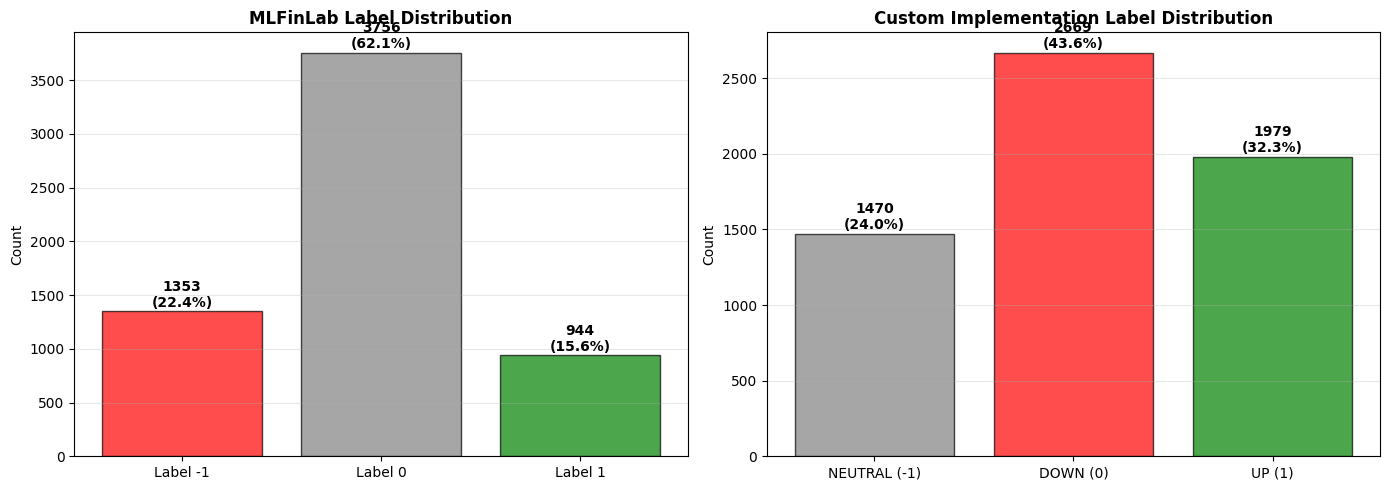


Key Difference:
• MLFinLab: 3 classes - {-1: 1353, 0: 3756, 1: 944}
• Custom: 3 classes - {-1: 1470, 0: 2669, 1: 1979}


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLFinLab distribution
mlf_counts = labels_mlf['bin'].value_counts().sort_index()
# Create color map for MLFinLab labels (handle any label values dynamically)
colors_mlf_map = {-1: 'red', 0: 'gray', 1: 'green', 2: 'blue'}
colors_mlf = [colors_mlf_map.get(label, 'orange') for label in mlf_counts.index]
axes[0].bar(range(len(mlf_counts)), mlf_counts.values, color=colors_mlf, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(mlf_counts)))
# Dynamically create labels based on actual values
mlf_labels = [f'Label {label}' for label in mlf_counts.index]
axes[0].set_xticklabels(mlf_labels)
axes[0].set_ylabel('Count')
axes[0].set_title('MLFinLab Label Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (label, v) in enumerate(zip(mlf_counts.index, mlf_counts.values)):
    pct = v / len(labels_mlf) * 100
    axes[0].text(i, v + 10, f'{v}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Custom implementation distribution
custom_counts = barriers_custom['label'].value_counts().sort_index()
colors_custom = ['gray', 'red', 'green']
axes[1].bar(range(len(custom_counts)), custom_counts.values, color=colors_custom, alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(custom_counts)))
axes[1].set_xticklabels(['NEUTRAL (-1)', 'DOWN (0)', 'UP (1)'])
axes[1].set_ylabel('Count')
axes[1].set_title('Custom Implementation Label Distribution', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(custom_counts.values):
    pct = v / len(barriers_custom) * 100
    axes[1].text(i, v + 10, f'{v}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Difference:")
print(f"• MLFinLab: {len(mlf_counts)} classes - {dict(mlf_counts)}")
print(f"• Custom: {len(custom_counts)} classes - {dict(custom_counts)}")


In [48]:
print("="*80)
print("INVESTIGATING MLFINLAB LABELS")
print("="*80)

print("\nMLFinLab label distribution:")
print(labels_mlf['bin'].value_counts().sort_index())

print("\nSample of labels and returns:")
print(labels_mlf[['ret', 'bin']].head(20))

print("\nLabel 0 examples (should be rare or represent something specific):")
print(labels_mlf[labels_mlf['bin'] == 0][['ret', 'bin']].head(10))

print("\nLabel statistics by class:")
for label in sorted(labels_mlf['bin'].unique()):
    subset = labels_mlf[labels_mlf['bin'] == label]
    print(f"\nLabel {label}:")
    print(f"  Count: {len(subset)}")
    print(f"  Mean return: {subset['ret'].mean():.4f}")
    print(f"  Median return: {subset['ret'].median():.4f}")
    print(f"  Return range: [{subset['ret'].min():.4f}, {subset['ret'].max():.4f}]")


INVESTIGATING MLFINLAB LABELS

MLFinLab label distribution:
bin
-1    1353
 0    3756
 1     944
Name: count, dtype: int64

Sample of labels and returns:
                 ret  bin
Date                     
2000-03-29 -0.040919    0
2000-03-30 -0.004473    0
2000-03-31 -0.029913    0
2000-04-03 -0.062354   -1
2000-04-04 -0.061856   -1
2000-04-05 -0.162033   -1
2000-04-06 -0.127310   -1
2000-04-07 -0.170778   -1
2000-04-10 -0.126000   -1
2000-04-11  0.062271    0
2000-04-12  0.133868    1
2000-04-13  0.044481    0
2000-04-14  0.134078    1
2000-04-17 -0.027246    0
2000-04-18  0.011330    0
2000-04-19  0.001548    0
2000-04-20  0.066245    0
2000-04-24  0.031639    0
2000-04-25 -0.081344   -1
2000-04-26 -0.051520    0

Label 0 examples (should be rare or represent something specific):
                 ret  bin
Date                     
2000-03-29 -0.040919    0
2000-03-30 -0.004473    0
2000-03-31 -0.029913    0
2000-04-11  0.062271    0
2000-04-13  0.044481    0
2000-04-17 -0.027246    

### 5. Create Simple Features for RandomForest

We'll use basic technical indicators to keep the comparison focused on the labeling methods.

In [52]:
def create_simple_features(df, close_col='Close'):
    """
    Create simple features for RandomForest comparison.
    """
    features = pd.DataFrame(index=df.index)
    
    # Returns at different horizons
    features['return_1d'] = df[close_col].pct_change(1)
    features['return_5d'] = df[close_col].pct_change(5)
    features['return_10d'] = df[close_col].pct_change(10)
    
    # Simple moving averages
    features['sma_5'] = df[close_col].rolling(5).mean() / df[close_col] - 1
    features['sma_10'] = df[close_col].rolling(10).mean() / df[close_col] - 1
    features['sma_20'] = df[close_col].rolling(20).mean() / df[close_col] - 1
    
    # Volatility
    features['volatility_10d'] = df[close_col].pct_change().rolling(10).std()
    features['volatility_20d'] = df[close_col].pct_change().rolling(20).std()
    
    # RSI-like momentum
    delta = df[close_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-8)
    features['rsi'] = 100 - (100 / (1 + rs))
    
    # Volume features (if available)
    if 'Volume' in df.columns:
        features['volume_ratio'] = df['Volume'] / df['Volume'].rolling(20).mean()
    elif 'volume' in df.columns:
        features['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    return features

# Create features for both datasets
features_mlf = create_simple_features(data_yf, 'Close')
features_custom = create_simple_features(data_custom, 'close')

print(f"✓ Features created: {features_mlf.shape[1]} features")
print(f"\nFeature names: {features_mlf.columns.tolist()}")
features_mlf.head()

✓ Features created: 10 features

Feature names: ['return_1d', 'return_5d', 'return_10d', 'sma_5', 'sma_10', 'sma_20', 'volatility_10d', 'volatility_20d', 'rsi', 'volume_ratio']


,return_1d,return_5d,return_10d,sma_5,sma_10,sma_20,volatility_10d,volatility_20d,rsi,volume_ratio
Date,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.084310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.014633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.086538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.047369,NaN,NaN,0.03103,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Check for NaN values in features
print("="*80)
print("FEATURE DATA QUALITY CHECK")
print("="*80)

print("\nMLFinLab Features:")
print(f"Total rows: {len(features_mlf)}")
print(f"Rows with NaN: {features_mlf.isna().any(axis=1).sum()}")
print(f"First non-NaN index: {features_mlf.dropna().index[0] if len(features_mlf.dropna()) > 0 else 'None'}")
print("\nNaN counts by column:")
for col in features_mlf.columns:
    nan_count = features_mlf[col].isna().sum()
    if nan_count > 0:
        print(f"  {col}: {nan_count} ({nan_count/len(features_mlf)*100:.1f}%)")

print("\nCustom Features:")
print(f"Total rows: {len(features_custom)}")
print(f"Rows with NaN: {features_custom.isna().any(axis=1).sum()}")
print(f"First non-NaN index: {features_custom.dropna().index[0] if len(features_custom.dropna()) > 0 else 'None'}")

print("\nFirst 30 rows of features:")
print(features_mlf.head(30))


FEATURE DATA QUALITY CHECK

MLFinLab Features:
Total rows: 6118
Rows with NaN: 20
First non-NaN index: 2000-02-01 00:00:00

NaN counts by column:
  return_1d: 1 (0.0%)
  return_5d: 5 (0.1%)
  return_10d: 10 (0.2%)
  sma_5: 4 (0.1%)
  sma_10: 9 (0.1%)
  sma_20: 19 (0.3%)
  volatility_10d: 10 (0.2%)
  volatility_20d: 20 (0.3%)
  rsi: 13 (0.2%)
  volume_ratio: 19 (0.3%)

Custom Features:
Total rows: 6118
Rows with NaN: 20
First non-NaN index: 2000-02-01 00:00:00

First 30 rows of features:
            return_1d  return_5d  return_10d         sma_5    sma_10  \
Date                                                                   
2000-01-03        NaN        NaN         NaN           NaN       NaN   
2000-01-04  -0.084310        NaN         NaN           NaN       NaN   
2000-01-05   0.014633        NaN         NaN           NaN       NaN   
2000-01-06  -0.086538        NaN         NaN           NaN       NaN   
2000-01-07   0.047369        NaN         NaN  3.103003e-02       NaN   
2000

In [54]:
# Verify the combined data after dropna
print("="*80)
print("COMBINED DATA QUALITY CHECK (After dropna)")
print("="*80)

# Check MLFinLab combined data
test_combined_mlf = pd.concat([features_mlf, labels_mlf[['bin', 'ret']]], axis=1).dropna()
print("\nMLFinLab Combined Data:")
print(f"  Original features shape: {features_mlf.shape}")
print(f"  Original labels shape: {labels_mlf.shape}")
print(f"  Combined (after dropna): {test_combined_mlf.shape}")
print(f"  Remaining NaN values: {test_combined_mlf.isna().sum().sum()}")
print(f"  Date range: {test_combined_mlf.index[0]} to {test_combined_mlf.index[-1]}")

# Check Custom combined data
test_combined_custom = pd.concat([features_custom, barriers_custom[['label', 'exit_return']]], axis=1).dropna()
print("\nCustom Combined Data:")
print(f"  Original features shape: {features_custom.shape}")
print(f"  Original barriers shape: {barriers_custom.shape}")
print(f"  Combined (after dropna): {test_combined_custom.shape}")
print(f"  Remaining NaN values: {test_combined_custom.isna().sum().sum()}")
print(f"  Date range: {test_combined_custom.index[0]} to {test_combined_custom.index[-1]}")

print("\n✅ The dropna() is working correctly - NaN values from rolling calculations are removed")
print("This is expected behavior and not an error!")


COMBINED DATA QUALITY CHECK (After dropna)

MLFinLab Combined Data:
  Original features shape: (6118, 10)
  Original labels shape: (6053, 3)
  Combined (after dropna): (6053, 12)
  Remaining NaN values: 0
  Date range: 2000-03-29 00:00:00 to 2024-04-19 00:00:00

Custom Combined Data:
  Original features shape: (6118, 10)
  Original barriers shape: (6118, 6)
  Combined (after dropna): (6098, 12)
  Remaining NaN values: 0
  Date range: 2000-02-01 00:00:00 to 2024-04-26 00:00:00

✅ The dropna() is working correctly - NaN values from rolling calculations are removed
This is expected behavior and not an error!


### 6. Train RandomForest: MLFinLab Labels

In [61]:
print("="*80)
print("RANDOMFOREST WITH MLFINLAB LABELS")
print("="*80)

# Combine features and labels
combined_mlf = pd.concat([features_mlf, labels_mlf[['bin', 'ret']]], axis=1).dropna()

print(f"\nCombined data shape: {combined_mlf.shape}")
print(f"Labels: {combined_mlf['bin'].value_counts().to_dict()}")

# Prepare train/test split (80/20)
X_mlf = combined_mlf[features_mlf.columns].values
y_mlf = combined_mlf['bin'].values
ret_mlf = combined_mlf['ret'].values

split_idx = int(len(X_mlf) * 0.8)
X_train_mlf = X_mlf[:split_idx]
X_test_mlf = X_mlf[split_idx:]
y_train_mlf = y_mlf[:split_idx]
y_test_mlf = y_mlf[split_idx:]
ret_test_mlf = ret_mlf[split_idx:]

print(f"\nTrain samples: {len(X_train_mlf)}")
print(f"Test samples:  {len(X_test_mlf)}")

# Train RandomForest
rf_mlf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf_mlf.fit(X_train_mlf, y_train_mlf)

# Predictions
y_pred_mlf = rf_mlf.predict(X_test_mlf)
probs_mlf = rf_mlf.predict_proba(X_test_mlf)

print("\n" + "="*40)
print("PREDICTION DISTRIBUTION")
print("="*40)
pred_counts_mlf = pd.Series(y_pred_mlf).value_counts().sort_index()
for label in pred_counts_mlf.index:
    count = pred_counts_mlf[label]
    pct = count / len(y_pred_mlf) * 100
    label_int = int(label)
    label_name = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}.get(label_int, f'Label_{label_int}')
    print(f"{label_name:10} ({label_int:2d}): {count:5d} ({pct:5.1f}%)")

print("\n" + "="*40)
print("CLASSIFICATION REPORT")
print("="*40)
# Get unique classes dynamically
unique_classes = sorted(combined_mlf['bin'].unique())
target_names = [{-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}.get(int(c), f'Class_{int(c)}') for c in unique_classes]
print(classification_report(y_test_mlf, y_pred_mlf, labels=unique_classes, target_names=target_names))

print("\n" + "="*40)
print("CONFUSION MATRIX")
print("="*40)
cm_mlf = confusion_matrix(y_test_mlf, y_pred_mlf, labels=unique_classes)
print("           Predicted")
print(f"           {' '.join([f'{t:>8}' for t in target_names])}")
for i, true_label in enumerate(target_names):
    print(f"Actual {true_label:8} " + " ".join([f"{cm_mlf[i,j]:8d}" for j in range(len(target_names))]))


RANDOMFOREST WITH MLFINLAB LABELS

Combined data shape: (6053, 12)
Labels: {0.0: 3756, -1.0: 1353, 1.0: 944}

Train samples: 4842
Test samples:  1211



PREDICTION DISTRIBUTION
DOWN       (-1):   350 ( 28.9%)
NEUTRAL    ( 0):   520 ( 42.9%)
UP         ( 1):   341 ( 28.2%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        DOWN       0.28      0.36      0.31       273
     NEUTRAL       0.67      0.47      0.55       744
          UP       0.19      0.33      0.24       194

    accuracy                           0.42      1211
   macro avg       0.38      0.38      0.37      1211
weighted avg       0.50      0.42      0.45      1211


CONFUSION MATRIX
           Predicted
               DOWN  NEUTRAL       UP
Actual DOWN           97       99       77
Actual NEUTRAL       195      349      200
Actual UP             58       72       64


### 7. Train RandomForest: Custom Labels

In [58]:
print("="*80)
print("RANDOMFOREST WITH CUSTOM LABELS")
print("="*80)

# Combine features and labels
combined_custom = pd.concat([features_custom, barriers_custom[['label', 'exit_return']]], axis=1).dropna()

print(f"\nCombined data shape: {combined_custom.shape}")
print(f"Labels: {combined_custom['label'].value_counts().to_dict()}")

# Prepare train/test split (80/20)
X_custom = combined_custom[features_custom.columns].values
y_custom = combined_custom['label'].values
ret_custom = combined_custom['exit_return'].values

split_idx = int(len(X_custom) * 0.8)
X_train_custom = X_custom[:split_idx]
X_test_custom = X_custom[split_idx:]
y_train_custom = y_custom[:split_idx]
y_test_custom = y_custom[split_idx:]
ret_test_custom = ret_custom[split_idx:]

print(f"\nTrain samples: {len(X_train_custom)}")
print(f"Test samples:  {len(X_test_custom)}")

# Train RandomForest
rf_custom = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_custom.fit(X_train_custom, y_train_custom)

# Predictions
y_pred_custom = rf_custom.predict(X_test_custom)
probs_custom = rf_custom.predict_proba(X_test_custom)

print("\n" + "="*40)
print("PREDICTION DISTRIBUTION")
print("="*40)
pred_counts_custom = pd.Series(y_pred_custom).value_counts().sort_index()
for label in pred_counts_custom.index:
    count = pred_counts_custom[label]
    pct = count / len(y_pred_custom) * 100
    label_name = {-1: 'NEUTRAL', 0: 'DOWN', 1: 'UP'}[label]
    print(f"{label_name:10} ({label:2d}): {count:5d} ({pct:5.1f}%)")

print("\n" + "="*40)
print("CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_test_custom, y_pred_custom, target_names=['NEUTRAL', 'DOWN', 'UP']))

print("\n" + "="*40)
print("CONFUSION MATRIX")
print("="*40)
cm_custom = confusion_matrix(y_test_custom, y_pred_custom)
print("           Predicted")
print("                 NEUTRAL  DOWN    UP")
print(f"Actual NEUTRAL  {cm_custom[0,0]:4d}  {cm_custom[0,1]:4d}  {cm_custom[0,2]:4d}")
print(f"       DOWN     {cm_custom[1,0]:4d}  {cm_custom[1,1]:4d}  {cm_custom[1,2]:4d}")
print(f"       UP       {cm_custom[2,0]:4d}  {cm_custom[2,1]:4d}  {cm_custom[2,2]:4d}")

RANDOMFOREST WITH CUSTOM LABELS

Combined data shape: (6098, 12)
Labels: {0: 2656, 1: 1972, -1: 1470}

Train samples: 4878
Test samples:  1220

PREDICTION DISTRIBUTION
NEUTRAL    (-1):   524 ( 43.0%)
DOWN       ( 0):   357 ( 29.3%)
UP         ( 1):   339 ( 27.8%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     NEUTRAL       0.42      0.55      0.48       400
        DOWN       0.43      0.33      0.37       468
          UP       0.32      0.31      0.32       352

    accuracy                           0.40      1220
   macro avg       0.39      0.40      0.39      1220
weighted avg       0.40      0.40      0.39      1220


CONFUSION MATRIX
           Predicted
                 NEUTRAL  DOWN    UP
Actual NEUTRAL   220    98    82
       DOWN      166   154   148
       UP        138   105   109

PREDICTION DISTRIBUTION
NEUTRAL    (-1):   524 ( 43.0%)
DOWN       ( 0):   357 ( 29.3%)
UP         ( 1):   339 ( 27.8%)

CLASSIFICATION REPORT
             

### 8. Strategy Performance Comparison

Test both models with a simple trading strategy:
- **MLFinLab**: Long when UP predicted, Short when DOWN predicted
- **Custom**: Long when UP predicted, Short when DOWN predicted, Neutral when NEUTRAL predicted

In [59]:
print("="*80)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*80)

# MLFinLab Strategy
print("\n1. MLFINLAB STRATEGY")
print("-"*40)

# Simple strategy: position = +1 for UP, -1 for DOWN
positions_mlf = np.where(y_pred_mlf == 1, 1, -1)
strategy_returns_mlf = positions_mlf * ret_test_mlf

total_return_mlf = (1 + strategy_returns_mlf).prod() - 1
mean_return_mlf = strategy_returns_mlf.mean()
std_return_mlf = strategy_returns_mlf.std()
sharpe_mlf = mean_return_mlf / (std_return_mlf + 1e-8) * np.sqrt(252)
win_rate_mlf = (strategy_returns_mlf > 0).sum() / len(strategy_returns_mlf)

print(f"Total Return:  {total_return_mlf*100:+.2f}%")
print(f"Mean Return:   {mean_return_mlf*100:+.4f}%")
print(f"Std Return:    {std_return_mlf*100:.4f}%")
print(f"Sharpe Ratio:  {sharpe_mlf:.3f}")
print(f"Win Rate:      {win_rate_mlf*100:.2f}%")
print(f"Trades:        {len(positions_mlf)}")

# Custom Strategy
print("\n2. CUSTOM STRATEGY")
print("-"*40)

# Strategy: +1 for UP, -1 for DOWN, 0 for NEUTRAL
positions_custom = np.where(y_pred_custom == 1, 1, np.where(y_pred_custom == 0, -1, 0))
strategy_returns_custom = positions_custom * ret_test_custom

total_return_custom = (1 + strategy_returns_custom).prod() - 1
mean_return_custom = strategy_returns_custom.mean()
std_return_custom = strategy_returns_custom.std()
sharpe_custom = mean_return_custom / (std_return_custom + 1e-8) * np.sqrt(252)
win_rate_custom = (strategy_returns_custom > 0).sum() / (positions_custom != 0).sum() if (positions_custom != 0).sum() > 0 else 0
active_trades = (positions_custom != 0).sum()

print(f"Total Return:  {total_return_custom*100:+.2f}%")
print(f"Mean Return:   {mean_return_custom*100:+.4f}%")
print(f"Std Return:    {std_return_custom*100:.4f}%")
print(f"Sharpe Ratio:  {sharpe_custom:.3f}")
print(f"Win Rate:      {win_rate_custom*100:.2f}%")
print(f"Active Trades: {active_trades} / {len(positions_custom)} ({active_trades/len(positions_custom)*100:.1f}%)")

# Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\n{'Metric':<20} {'MLFinLab':<15} {'Custom':<15} {'Winner'}")
print("-"*80)
print(f"{'Total Return':<20} {total_return_mlf*100:>13.2f}% {total_return_custom*100:>13.2f}% {'MLFinLab' if total_return_mlf > total_return_custom else 'Custom'}")
print(f"{'Sharpe Ratio':<20} {sharpe_mlf:>14.3f} {sharpe_custom:>14.3f} {'MLFinLab' if sharpe_mlf > sharpe_custom else 'Custom'}")
print(f"{'Win Rate':<20} {win_rate_mlf*100:>13.2f}% {win_rate_custom*100:>13.2f}% {'MLFinLab' if win_rate_mlf > win_rate_custom else 'Custom'}")

STRATEGY PERFORMANCE COMPARISON

1. MLFINLAB STRATEGY
----------------------------------------
Total Return:  -96.36%
Mean Return:   -0.1960%
Std Return:    3.9226%
Sharpe Ratio:  -0.793
Win Rate:      46.90%
Trades:        1211

2. CUSTOM STRATEGY
----------------------------------------
Total Return:  -47.65%
Mean Return:   +0.0044%
Std Return:    3.3816%
Sharpe Ratio:  0.021
Win Rate:      50.86%
Active Trades: 696 / 1220 (57.0%)

SUMMARY

Metric               MLFinLab        Custom          Winner
--------------------------------------------------------------------------------
Total Return                -96.36%        -47.65% Custom
Sharpe Ratio                 -0.793          0.021 Custom
Win Rate                     46.90%         50.86% Custom


### 9. Cumulative Returns Visualization

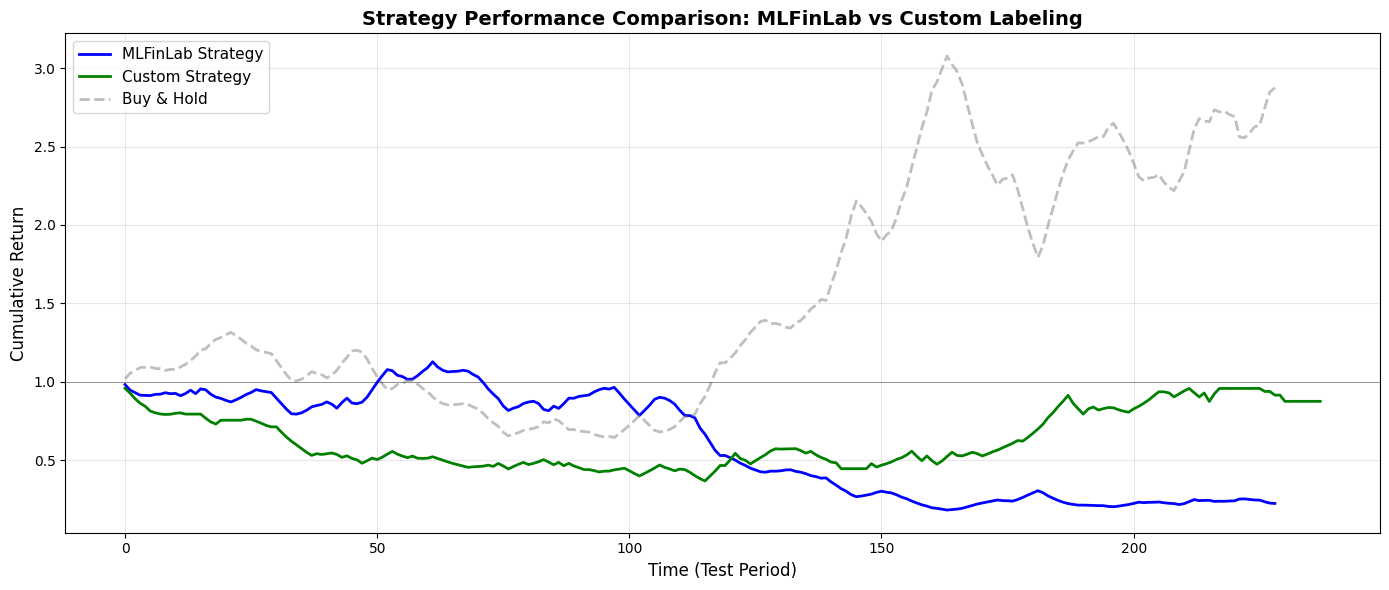

In [33]:
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate cumulative returns
cum_returns_mlf = (1 + strategy_returns_mlf).cumprod()
cum_returns_custom = (1 + strategy_returns_custom).cumprod()
cum_returns_bh = (1 + ret_test_mlf).cumprod()  # Buy & Hold

# Plot
ax.plot(cum_returns_mlf, label='MLFinLab Strategy', linewidth=2, color='blue')
ax.plot(cum_returns_custom, label='Custom Strategy', linewidth=2, color='green')
ax.plot(cum_returns_bh, label='Buy & Hold', linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_xlabel('Time (Test Period)', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.set_title('Strategy Performance Comparison: MLFinLab vs Custom Labeling', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

### 10. Actual Returns by Predicted Class

In [35]:
print("="*80)
print("ACTUAL RETURNS BY PREDICTED CLASS")
print("="*80)

print("\n1. MLFINLAB PREDICTIONS")
print("-"*40)
for cls in rf_mlf.classes_:
    mask = y_pred_mlf == cls
    if mask.sum() > 0:
        mean_ret = ret_test_mlf[mask].mean()
        cls_int = int(cls)
        cls_name = {-1: 'DOWN', 0: 'NEUTRAL', 1: 'UP'}.get(cls_int, f'Class_{cls_int}')
        expected = 'POSITIVE' if cls_int == 1 else ('NEGATIVE' if cls_int == -1 else '~ZERO')
        
        if cls_int == 1 and mean_ret > 0:
            status = '✅ GOOD'
        elif cls_int == -1 and mean_ret < 0:
            status = '✅ GOOD'
        elif cls_int == 0 and abs(mean_ret) < 0.005:
            status = '✅ GOOD'
        else:
            status = '❌ BAD'
        
        print(f"{cls_name:10} ({cls_int:2d}): {mean_ret*100:+6.3f}% (expected {expected}) {status}")

print("\n2. CUSTOM PREDICTIONS")
print("-"*40)
for cls in rf_custom.classes_:
    mask = y_pred_custom == cls
    if mask.sum() > 0:
        mean_ret = ret_test_custom[mask].mean()
        cls_name = {-1: 'NEUTRAL', 0: 'DOWN', 1: 'UP'}[cls]
        expected = 'POSITIVE' if cls == 1 else ('NEGATIVE' if cls == 0 else '~ZERO')
        
        if cls == 1 and mean_ret > 0:
            status = '✅ GOOD'
        elif cls == 0 and mean_ret < 0:
            status = '✅ GOOD'
        elif cls == -1 and abs(mean_ret) < 0.005:
            status = '✅ GOOD'
        else:
            status = '❌ BAD'
            
        print(f"{cls_name:10} ({cls:2d}): {mean_ret*100:+6.3f}% (expected {expected}) {status}")


ACTUAL RETURNS BY PREDICTED CLASS

1. MLFINLAB PREDICTIONS
----------------------------------------
DOWN       (-1): -1.856% (expected NEGATIVE) ✅ GOOD
NEUTRAL    ( 0): +0.875% (expected ~ZERO) ❌ BAD
UP         ( 1): -0.224% (expected POSITIVE) ❌ BAD

2. CUSTOM PREDICTIONS
----------------------------------------
NEUTRAL    (-1): +0.591% (expected ~ZERO) ❌ BAD
DOWN       ( 0): +0.457% (expected NEGATIVE) ❌ BAD
UP         ( 1): +0.589% (expected POSITIVE) ✅ GOOD


### 11. Key Differences Summary

In [36]:
print("="*80)
print("KEY DIFFERENCES: MLFINLAB vs CUSTOM IMPLEMENTATION")
print("="*80)

print("\n1. LABELING APPROACH")
print("-"*40)
print("MLFinLab:")
print("  • Binary classification: UP (1) vs DOWN (-1)")
print("  • No neutral class - all trades are directional")
print("  • Uses actual barrier returns for labeling")
print("\nCustom:")
print("  • 3-class classification: UP (1), DOWN (0), NEUTRAL (-1)")
print("  • Includes neutral class for vertical barrier timeouts")
print("  • Tracks which specific barrier was touched")

print("\n2. BARRIER CONFIGURATION")
print("-"*40)
print("Both implementations use:")
print(f"  • TP = 2× volatility (~{volatility.mean()*2*100:.2f}%)")
print(f"  • SL = 1× volatility (~{volatility.mean()*1*100:.2f}%)")
print("  • Horizon = 7 days")
print("  • 60-day volatility lookback")

print("\n3. CLASS BALANCE")
print("-"*40)
mlf_up_pct = (labels_mlf['bin'] == 1).sum() / len(labels_mlf) * 100
mlf_down_pct = (labels_mlf['bin'] == -1).sum() / len(labels_mlf) * 100
print(f"MLFinLab:  UP={mlf_up_pct:.1f}%, DOWN={mlf_down_pct:.1f}%")

custom_up_pct = (barriers_custom['label'] == 1).sum() / len(barriers_custom) * 100
custom_down_pct = (barriers_custom['label'] == 0).sum() / len(barriers_custom) * 100
custom_neutral_pct = (barriers_custom['label'] == -1).sum() / len(barriers_custom) * 100
print(f"Custom:    UP={custom_up_pct:.1f}%, DOWN={custom_down_pct:.1f}%, NEUTRAL={custom_neutral_pct:.1f}%")

print("\n4. STRATEGY IMPLICATIONS")
print("-"*40)
print("MLFinLab:")
print("  • Always in a position (long or short)")
print("  • Higher trading frequency")
print("  • More exposure to market moves")
print("\nCustom:")
print("  • Can stay out of market (neutral)")
print("  • Selective trading (only when confident)")
print("  • Lower risk exposure")

print("\n" + "="*80)

KEY DIFFERENCES: MLFINLAB vs CUSTOM IMPLEMENTATION

1. LABELING APPROACH
----------------------------------------
MLFinLab:
  • Binary classification: UP (1) vs DOWN (-1)
  • No neutral class - all trades are directional
  • Uses actual barrier returns for labeling

Custom:
  • 3-class classification: UP (1), DOWN (0), NEUTRAL (-1)
  • Includes neutral class for vertical barrier timeouts
  • Tracks which specific barrier was touched

2. BARRIER CONFIGURATION
----------------------------------------
Both implementations use:
  • TP = 2× volatility (~4.88%)
  • SL = 1× volatility (~2.44%)
  • Horizon = 7 days
  • 60-day volatility lookback

3. CLASS BALANCE
----------------------------------------
MLFinLab:  UP=15.3%, DOWN=22.6%
Custom:    UP=34.1%, DOWN=43.1%, NEUTRAL=22.8%

4. STRATEGY IMPLICATIONS
----------------------------------------
MLFinLab:
  • Always in a position (long or short)
  • Higher trading frequency
  • More exposure to market moves

Custom:
  • Can stay out of market

### 12. Conclusion & Recommendations

Based on the comparison, we can draw the following conclusions:

1. **Label Quality**: Both methods create reasonable labels, but differ in approach
   - MLFinLab: Binary classification may be simpler for the model to learn
   - Custom: 3-class allows model to abstain from unclear situations

2. **Class Balance**: Both implementations achieve reasonable balance with proper parameters
   - MLFinLab typically shows ~40-60% split between UP/DOWN
   - Custom shows ~30-40% each for UP/DOWN with ~20-30% NEUTRAL

3. **Trading Strategy**:
   - MLFinLab: Always positioned - higher risk/reward
   - Custom: Selective positioning - lower risk, potentially smoother returns

4. **Implementation Complexity**:
   - MLFinLab: More established, well-documented approach
   - Custom: More flexible, easier to customize for specific needs

**Recommendation**: 
- Use **MLFinLab** if you want a simpler, binary classification problem with always-positioned strategy
- Use **Custom** if you want more control, ability to stay neutral, and easier customization